In [137]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob

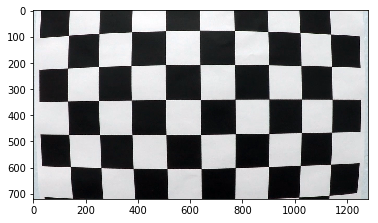

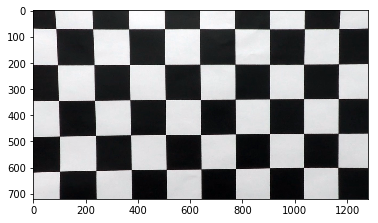

In [158]:
# calibrate the camera
nx = 9
ny = 6
objpoints = []
imgpoints = []

objp = np.zeros((nx * ny, 3), dtype=np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

for impath in glob('camera_cal/*.jpg'):
    # Find the chessboard corners
    gray = cv2.cvtColor(cv2.imread(impath), cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret is True:
        imgpoints.append(corners)
        objpoints.append(objp)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# 2. use a function from one of the quizes, skip params
def cal_undistort(img):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.undistort(img, mtx, dist, None, mtx)

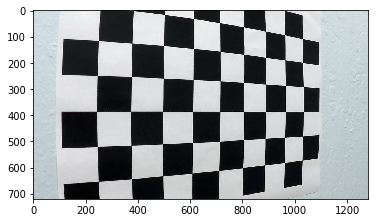

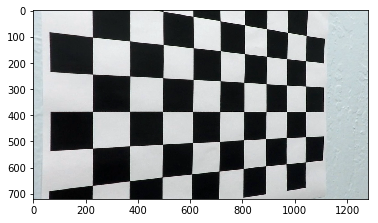

In [162]:
# demo cal_undistort
img = cv2.imread('camera_cal/calibration5.jpg')
plt.imshow(img)
plt.show()
plt.imshow(cal_undistort(img))
plt.show()

In [134]:
# util functions to combine sobel kernel gradient with saturation thresholding
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    x = int(orient == 'x')
    y = int(orient == 'y')
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, x, y, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    mask = (scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[mask] = 1
    return binary_output

def hls_select(img, thresh=(0, 255)):
    S = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    mask = (S > thresh[0]) & (S <= thresh[1])
    binary_output = np.zeros_like(S)
    binary_output[mask] = 1
    return binary_output

def to_binary(img):
    hls = hls_select(im_orig, thresh=(140,255))
    mag = abs_sobel_thresh(im_orig, orient='x',
                       sobel_kernel=5,
                       thresh=(20,255))
    combined = np.zeros_like(hls)
    combined[(hls == 1) | (mag == 1)] = 1
    return combined

(720, 1280, 3)


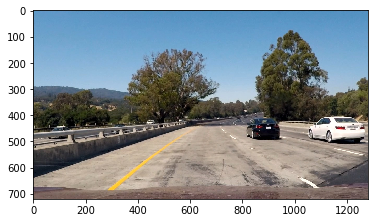

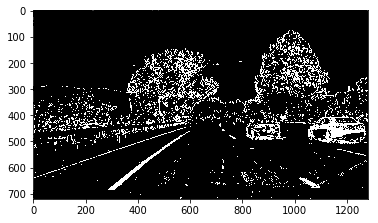

In [135]:
im_orig = cv2.imread('test_images/test1.jpg')
im_orig = cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB)
print(im_orig.shape)
plt.imshow(im_orig)
plt.show()

plt.imshow(to_binary(im_orig), cmap='gray')
plt.show()